In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader 
from torch.autograd import Variable
from tqdm import trange

torch.manual_seed(0)

In [2]:
if torch.cuda.is_available():  
    device = "cuda:0" 
else:  
    device = "cpu"  
    
#https://www.kaggle.com/code/anthokalel/statistical-tests-lstm-pytorch/notebook

In [3]:
X = pd.read_csv("../data/processed/gw_stage2.CSV",
                    parse_dates=['Datetime'],
                    index_col=['Datetime'])
print('Initial Input Size: ',X.shape)
y = pd.read_csv("../data/processed/spring.CSV",
                    parse_dates=['datetime'],
                    index_col=['datetime'])
key_value = np.loadtxt("../data/processed/NameKey2.CSV", dtype= "str", delimiter=",", skiprows=1)
stationNames = { k:v for k,v in key_value }
#print(stationNames)
tooClose=['8','9','10','12','13','14','25', '44', '61', '72']
for i in tooClose:
    print(stationNames[i])

#Drop values exctremely close to the Sprin head
X.drop(X.columns[[8,9,10,12,13, 14, 25,44,61,72]], axis=1, inplace=True)
print("Excluded GW-SW Input Shape: ", X.shape)
X.rename(columns = stationNames, inplace = True)
GW=X.iloc[:,:23]
SW=X.iloc[:,23:]
met=pd.read_csv("../data/processed/DailyMet.CSV",
                parse_dates=['Datetime'],
                index_col=['Datetime'])

X=pd.concat([X, met], axis=1)
#print(X)
MET=X.iloc[:,-5:]
#print(X)
train_names=X.columns


#Add Y columns as a separate column
y['timestamp']=y.index
y['timestamp']=pd.to_datetime(y['timestamp']).dt.tz_convert(None)
#=pd.to_datetime(['timestamp'], format='%Y-%m-%d %H:%M:%S')
y=y.rename(columns={'Gage_Height':'Wakulla', 'timestamp':'Datetime'})
y=y.set_index('Datetime')

df=X.merge(y, how='inner', right_index=True, left_index=True)
met_df=MET.merge(y,how='inner', right_index=True, left_index=True)
met_names=MET.columns
del(X,y)

#GW
met_df

Initial Input Size:  (1101, 74)
NWFWMD-NITRATE 1
NWFWMD-NITRATE 2/S790
NWFWMD-NITRATE 4/S782
NWFWMD-NITRATE 6/S797
WAKULLA CORRECTIONAL INSTITUTE 1/S779
WAKULLA CONDUIT WELL@WEST OF HWY 61
NWFWMD GW-12F (RIVERSPRINGS MS)/S820
St  Marks River @ San Marcos de Apalachee S P 
WAKULLA RIVER AT BOAT TRAM
INDIAN SPRING RUN AT SR61
Excluded GW-SW Input Shape:  (1101, 64)


,Precip,Max_Temp,Min_Temp,Mean_Temp,PET,Wakulla
Datetime,,,,,,
2017-01-27,0.00000,58,39,48.5,3.189802,5.470909
2017-01-28,0.00000,51,38,44.5,2.403944,5.418021
2017-01-29,0.00000,63,38,50.5,3.755256,5.345313
2017-01-30,0.00000,65,31,48.0,4.131664,5.237917
2017-01-31,0.00000,75,35,55.0,5.095131,5.171563
...,...,...,...,...,...,...
2020-01-28,0.00000,67,36,51.5,4.295638,4.814896
2020-01-29,0.06000,53,35,44.0,2.776629,4.811146
2020-01-30,0.00000,65,48,56.5,3.438450,4.807292


In [4]:
def scale_and_split(df):
    train, val = train_test_split(df, test_size=0.35, shuffle = False)
    val, test = train_test_split(val, test_size=0.6, shuffle = False)
    
    #Use train set as the sclaer to prevent data leakage
    X_scaler = StandardScaler().fit(train.iloc[:,:-1])
    train_Xscaled = X_scaler.transform(train.iloc[:,:-1])
    y_scaler= MinMaxScaler().fit(train.iloc[:,-1:])
    train_yscaled= y_scaler.transform(train.iloc[:,-1:])
    
    train_scaled = pd.DataFrame(np.append(train_Xscaled, train_yscaled,1), columns = df.columns[:])
 
    
    val_Xscaled = X_scaler.transform(val.iloc[:,:-1])
    val_yscaled= y_scaler.transform(val.iloc[:,-1:])
    val_scaled = pd.DataFrame(np.append(val_Xscaled, val_yscaled,1), columns = df.columns[:])
    
    test_Xscaled = X_scaler.transform(test.iloc[:,:-1])
    test_yscaled= y_scaler.transform(test.iloc[:,-1:])
    test_scaled = pd.DataFrame(np.append(test_Xscaled, test_yscaled,1), columns = df.columns[:])
    
    full_scaled_X=X_scaler.transform(df.iloc[:,:-1])
    full_scaled_y=y_scaler.transform(df.iloc[:,-1:])
    
    return train_scaled, val_scaled, test_scaled, X_scaler, y_scaler, full_scaled_X, full_scaled_y

#Old one

def prepare_inputs_outputs(train, val, test, seq_len, inputs, output):   
    X_train, y_train = train[:len(train)-seq_len][inputs], train[[output]]
    X_val, y_val = val[:len(val)-seq_len][inputs], val[[output]]
    X_test, y_test = test[:len(val)-seq_len][inputs], test[[output]]
    #test[:len(test)-seq_len][inputs], test[[output]]
    return X_train, y_train, X_val, y_val, X_test, y_test

'''
## Try New One
def prepare_inputs_outputs(train, val, test, seq_len, inputs, output):   
    X_train, y_train = train[inputs], train[output][seq_len-1:]
    X_val, y_val = val[:len(val)-seq_len][inputs], val[[output]]
    X_test, y_test = test[:len(test)-seq_len][inputs], test[[output]]
    return X_train, y_train, X_val, y_val, X_test, y_test
'''
###Theory here is that we take [seq_len] numbered away from trainX and pass it to Val_X 
#and same with val to Test set
#May not be necessary

'\n## Try New One\ndef prepare_inputs_outputs(train, val, test, seq_len, inputs, output):   \n    X_train, y_train = train[inputs], train[output][seq_len-1:]\n    X_val, y_val = val[:len(val)-seq_len][inputs], val[[output]]\n    X_test, y_test = test[:len(test)-seq_len][inputs], test[[output]]\n    return X_train, y_train, X_val, y_val, X_test, y_test\n'

In [5]:
parameters = {'inputs':met_names,
              'input_size': len(met_names),
              'outputs':['Wakulla'],
              'seq_len': 40,
              'hidden_size': 32, #Same as batch
              'batch_size_train':64,
              'batch_size_val':8,
              'batch_size_test':8,
              'lr':0.0005,
              'epochs':40,
              'num_layers':1   #Number of LSTM layers
             }

train, val, test, X_scaler, y_scaler, full_scaled_X, full_scaled_y = scale_and_split(met_df) 
#inputs=parameters['inputs']
#output=parameters['outputs'][0]
#seq_len=parameters['seq_len']
#rint(train[output][seq_len-1:])




X_train, y_train, X_val, y_val, X_test, y_test = prepare_inputs_outputs(train, val, test, 
                                                                        parameters['seq_len'], 
                                                                        parameters['inputs'], 
                                                                        parameters['outputs'][0])
print(len(y_train)+len(y_val)+len(y_test))                                                           

1101


In [6]:
class TimeSeries(Dataset):
    def __init__(self, X, y, seq_len):
        self.X = torch.tensor(np.array(X) ,dtype=torch.float32)
        self.y = torch.tensor(np.array(y) ,dtype=torch.float32)
        #self.column_input = column_input
        #self.column_output = column_output
        self.seq_len = seq_len
        
    #Gets the input sequence [X : X +seq_len], adn the corresponding, singular y+seq_len    
    def __getitem__(self,idx):
        return self.X[idx:idx+self.seq_len-1], self.y[idx+self.seq_len-1]

    def __len__(self):
        return len(self.X) - (self.seq_len-1)
    
    
def get_dataloader(X, y,seq_len, batch_size):
    return DataLoader(TimeSeries(X, y, seq_len),  batch_size, shuffle=False, drop_last = True)

## Test different LSTM architecture Combinations
We will train a number of LSTM combinations on just meteorological data to see which performs the best.

In [7]:
##1 LSTM LAYER

class LSTM_FC(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length):
        super().__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc1 =  nn.Linear(hidden_size, 1) #fully connected 1
    
    def forward(self,x):   
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        #hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.fc1(hn)#first Dense
        return out
    

class LSTM_RELU_FC(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length):
        super().__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.relu= nn.ReLU()
        self.fc1 =  nn.Linear(hidden_size, 1) #fully connected 1
    
         
    
    def forward(self,x):   
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        out = self.relu(hn)
        out = self.fc1(out)#first Dense
       
        return out
class LSTM_DROP_FC(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length):
        super().__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.dropout=nn.Dropout(0.1)
        self.fc1 =  nn.Linear(hidden_size, 1) #fully connected 1
   
    def forward(self,x):   
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        out=self.dropout(hn)
        out = self.fc1(out)#first Dense
        return out

class LSTM_DROP_RELU_FC(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length):
        super().__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.dropout=nn.Dropout(0.1)
        self.relu= nn.ReLU()
        self.fc1 =  nn.Linear(hidden_size, 1) #fully connected 1
        #self.sigmoid=nn.Sigmoid()
         
    
    def forward(self,x):   
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        out=self.dropout(hn)
        out = self.relu(out)
        out = self.fc1(out)#first Dense
        return out
class LSTM_RELU_DROP_FC(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length):
        super().__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.dropout=nn.Dropout(0.1)
        self.relu= nn.ReLU()
        self.fc1 =  nn.Linear(hidden_size, 1) #fully connected to 1
         
    def forward(self,x):   
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        out = self.relu(hn)
        out=self.dropout(out)
        out = self.fc1(out)#first Dense
        return out
##1 LSTM LAYER

class LSTM_FC_FC(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length):
        super().__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc =  nn.Linear(hidden_size, hidden_size)
        self.fc1 =  nn.Linear(hidden_size, 1) #fully connected 1
    
    def forward(self,x):   
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        #hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.fc(hn)#first Dense
        out = self.fc1(out)#first Dense
        return out

class LSTM_FC_DROP_FC(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length):
        super().__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length
        self.dropout=nn.Dropout(0.1)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc =  nn.Linear(hidden_size, hidden_size)
        self.fc1 =  nn.Linear(hidden_size, 1) #fully connected 1
    
    def forward(self,x):   
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        #hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.fc(hn)#first Dense
        out = self.dropout(out)
        out = self.fc1(out)#first Dense
        return out
###################################################


    
class LSTM_LSTM_RELU_FC(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length):
        super().__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.dropout=nn.Dropout(0.1)

        self.fc =  nn.Linear(hidden_size, hidden_size) #fully connected 1
        self.relu= nn.ReLU()
        self.fc1 =  nn.Linear(hidden_size, 1) #fully connected 1
        #self.sigmoid=nn.Sigmoid()
         
    
    def forward(self,x):   
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        #hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        #out=self.dropout(hn)
        output, (hn, cn) = self.lstm(x, (hn, cn))
        #out = self.fc(hn)#first Dense
        out = self.relu(hn)
       # out = self.sigmoid(out)
        #out=self.dropout(out)
        out = self.fc1(out)#first Dense
        #out = self.relu(out)
        return out
    

class LSTM_DROP_FC_RELU_FC(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length):
        super().__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.dropout=nn.Dropout(0.1)

        self.fc =  nn.Linear(hidden_size, hidden_size) #fully connected 1
        self.relu= nn.ReLU()
        self.fc1 =  nn.Linear(hidden_size, 1) #fully connected 1
        #self.sigmoid=nn.Sigmoid()
         
    
    def forward(self,x):   
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        #hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out=self.dropout(hn)
        #output, (hn, cn) = self.lstm(x, (hn, cn))
        out = self.fc(out)#first Dense
        out = self.relu(out)
       # out = self.sigmoid(out)
        #out=self.dropout(out)
        out = self.fc1(out)#first Dense
        #out = self.relu(out)
        return out
class LSTM_FC_RELU_FC(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length):
        super().__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.dropout=nn.Dropout(0.1)

        self.fc =  nn.Linear(hidden_size, hidden_size) #fully connected 1
        self.relu= nn.ReLU()
        self.fc1 =  nn.Linear(hidden_size, 1) #fully connected 1
        #self.sigmoid=nn.Sigmoid()
         
    
    def forward(self,x):   
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        #hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        #out=self.dropout(hn)
        #output, (hn, cn) = self.lstm(x, (out, cn))
        out = self.fc(hn)#first Dense
        out = self.relu(out)
       # out = self.sigmoid(out)
        #out=self.dropout(out)
        out = self.fc1(out)#first Dense
        #out = self.relu(out)
        return out

    
class LSTM_DROP_LSTM_FC_RELU_FC(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length):
        super().__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.dropout=nn.Dropout(0.1)

        self.fc =  nn.Linear(hidden_size, hidden_size) #fully connected 1
        self.relu= nn.ReLU()
        self.fc1 =  nn.Linear(hidden_size, 1) #fully connected 1
        #self.sigmoid=nn.Sigmoid()
         
    
    def forward(self,x):   
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        #hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out=self.dropout(hn)
        output, (hn, cn) = self.lstm(x, (out, cn))
        out = self.fc(hn)#first Dense
        out = self.relu(out)
       # out = self.sigmoid(out)
        #out=self.dropout(out)
        out = self.fc1(out)#first Dense
        #out = self.relu(out)
        return out

class LSTM_LSTM_FC_RELU_FC(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length):
        super().__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.dropout=nn.Dropout(0.1)

        self.fc =  nn.Linear(hidden_size, hidden_size) #fully connected 1
        self.relu= nn.ReLU()
        self.fc1 =  nn.Linear(hidden_size, 1) #fully connected 1
        #self.sigmoid=nn.Sigmoid()
         
    
    def forward(self,x):   
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        #hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        #out=self.dropout(hn)
        output, (hn, cn) = self.lstm(x, (hn, cn))
        out = self.fc(hn)#first Dense
        out = self.relu(out)
       # out = self.sigmoid(out)
        #out=self.dropout(out)
        out = self.fc1(out)#first Dense
        #out = self.relu(out)
        return out
    

class LSTM_LSTM_FC_DROP_FC(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length):
        super().__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.dropout=nn.Dropout(0.1)

        self.fc =  nn.Linear(hidden_size, hidden_size) #fully connected 1
        self.relu= nn.ReLU()
        self.fc1 =  nn.Linear(hidden_size, 1) #fully connected 1
        #self.sigmoid=nn.Sigmoid()
         
    
    def forward(self,x):   
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        #hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        #out=self.dropout(hn)
        output, (hn, cn) = self.lstm(x, (hn, cn))
        out = self.fc(hn)#first Dense
        #out = self.relu(out)
       # out = self.sigmoid(out)
        out=self.dropout(out)
        out = self.fc1(out)#first Dense
        #out = self.relu(out)
        return out
class LSTM_LSTM_FC_DROP_RELU_FC(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length):
        super().__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.dropout=nn.Dropout(0.1)

        self.fc =  nn.Linear(hidden_size, hidden_size) #fully connected 1
        self.relu= nn.ReLU()
        self.fc1 =  nn.Linear(hidden_size, 1) #fully connected 1
        #self.sigmoid=nn.Sigmoid()
         
    
    def forward(self,x):   
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        #hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        #out=self.dropout(hn)
        output, (hn, cn) = self.lstm(x, (hn, cn))
        out = self.fc(hn)#first Dense
       # out = self.sigmoid(out)
        out=self.dropout(out)
        out = self.relu(out)
        out = self.fc1(out)#first Dense
        #out = self.relu(out)
        return out

In [8]:
lstm_fc=LSTM_FC(parameters['input_size'], parameters['hidden_size'], parameters['num_layers'], parameters['seq_len'])
lstm_relu_fc=LSTM_RELU_FC(parameters['input_size'], parameters['hidden_size'], parameters['num_layers'], parameters['seq_len'])
lstm_drop_fc=LSTM_DROP_FC(parameters['input_size'], parameters['hidden_size'], parameters['num_layers'], parameters['seq_len'])
lstm_drop_relu_fc=LSTM_DROP_RELU_FC(parameters['input_size'], parameters['hidden_size'], parameters['num_layers'], parameters['seq_len'])
lstm_relu_drop_fc=LSTM_RELU_DROP_FC(parameters['input_size'], parameters['hidden_size'], parameters['num_layers'], parameters['seq_len'])
lstm_lstm_relu_fc=LSTM_LSTM_RELU_FC(parameters['input_size'], parameters['hidden_size'], parameters['num_layers'], parameters['seq_len'])
lstm_drop_fc_relu_fc=LSTM_DROP_FC_RELU_FC(parameters['input_size'], parameters['hidden_size'], parameters['num_layers'], parameters['seq_len'])
lstm_drop_lstm_fc_relu_fc=LSTM_DROP_LSTM_FC_RELU_FC(parameters['input_size'], parameters['hidden_size'], parameters['num_layers'], parameters['seq_len'])
lstm_lstm_fc_relu_fc=LSTM_LSTM_FC_RELU_FC(parameters['input_size'], parameters['hidden_size'], parameters['num_layers'], parameters['seq_len'])
lstm_lstm_fc_drop_fc=LSTM_LSTM_FC_DROP_FC(parameters['input_size'], parameters['hidden_size'], parameters['num_layers'], parameters['seq_len'])
lstm_lstm_fc_drop_relu_fc=LSTM_LSTM_FC_DROP_RELU_FC(parameters['input_size'], parameters['hidden_size'], parameters['num_layers'], parameters['seq_len'])
lstm_fc_relu_fc=LSTM_FC_RELU_FC(parameters['input_size'], parameters['hidden_size'], parameters['num_layers'], parameters['seq_len'])
lstm_fc_fc=LSTM_FC_FC(parameters['input_size'], parameters['hidden_size'], parameters['num_layers'], parameters['seq_len'])
lstm_fc_drop_fc=LSTM_FC_DROP_FC(parameters['input_size'], parameters['hidden_size'], parameters['num_layers'], parameters['seq_len'])


model_list=[lstm_fc, lstm_relu_fc, lstm_drop_fc, lstm_drop_relu_fc, lstm_relu_drop_fc,
            lstm_lstm_relu_fc, lstm_drop_fc_relu_fc, lstm_drop_lstm_fc_relu_fc, lstm_lstm_fc_relu_fc,
            lstm_lstm_fc_drop_fc, lstm_lstm_fc_drop_relu_fc, lstm_fc_fc, lstm_fc_relu_fc, lstm_fc_drop_fc]


In [9]:
def train_model(model, train_loader, val_loader, loss_function, optimizer, epochs):


    train_val_history = {'train': [],
                        'val': []}
    for i in trange(epochs):
        for j, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            #print(inputs.shape)
            y_pred = model(inputs)
            #print(y_pred.shape)
            labels_3D=labels.reshape(1,labels.shape[0],labels.shape[1])
           
            single_loss = torch.sqrt(loss_function(y_pred, labels_3D)) #RMSE

            single_loss.backward()

            optimizer.step()

        train_val_history['train'].append(single_loss.item())
        #print("Training data : " + f'epoch: {i:3} loss: {single_loss.item():10.8f}')

        for j, data in enumerate(val_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            labels_3D=labels.reshape(1,labels.shape[0],labels.shape[1])
            y_pred = model(inputs)

            single_loss = torch.sqrt(loss_function(y_pred, labels_3D))

        train_val_history['val'].append(single_loss.item())
        #if i % 20 == 0:
            #print("Training data : epoch: ", i, " loss: ", train_val_history['train'][-1])
            #print("Validation data :  epoch: ", i, " loss: ", train_val_history['val'][-1])

    #print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
    return model, train_val_history

In [10]:
train_loader = get_dataloader(X_train, y_train, parameters['seq_len'],parameters['batch_size_train'])
val_loader = get_dataloader(X_val, y_val, parameters['seq_len'],parameters['batch_size_val'])
test_loader = get_dataloader(X_test, y_test, parameters['seq_len'], parameters['batch_size_test'])
full_loader=get_dataloader(full_scaled_X, full_scaled_y, parameters['seq_len'], parameters['batch_size_test'])
#model = New_LSTM(input_size=len(parameters['inputs']), hidden_layer_size=64, output_size=1, seq_len=parameters['seq_len']).to(device)


In [11]:
from sklearn.metrics import mean_squared_error as mse
from hydroeval import evaluator, nse, kge, kgeprime


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.69it/s]

LSTM_FC(
  (lstm): LSTM(5, 32, batch_first=True)
  (fc1): Linear(in_features=32, out_features=1, bias=True)
)


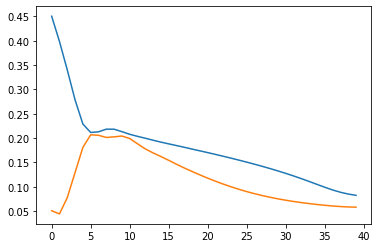

train  MSE:  0.06988022285431379
val  MSE:  0.16845940413288296
Test NSE: [-0.65736592]
Test KGE: 0.39352870881450597
test  MSE:  0.11887731124233936
Full NSE: [0.47788072]
Full KGE: 0.6408867287096269
Full  MSE:  0.1138498838951767


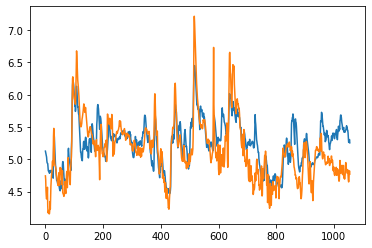

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.46it/s]

LSTM_RELU_FC(
  (lstm): LSTM(5, 32, batch_first=True)
  (relu): ReLU()
  (fc1): Linear(in_features=32, out_features=1, bias=True)
)


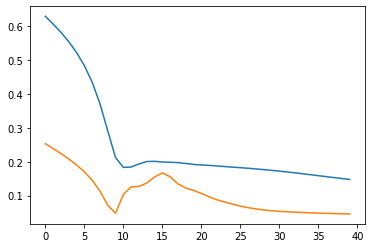

train  MSE:  0.0986235228479685
val  MSE:  0.18573623860078842
Test NSE: [-2.35858821]
Test KGE: 0.25694994435980534
test  MSE:  0.2409002935309767
Full NSE: [0.34822933]
Full KGE: 0.4977709834874683
Full  MSE:  0.1421208078715169


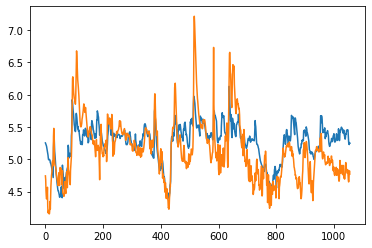

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.59it/s]

LSTM_DROP_FC(
  (lstm): LSTM(5, 32, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=32, out_features=1, bias=True)
)


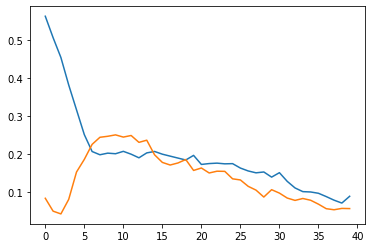

train  MSE:  0.07195797961325129
val  MSE:  0.1355070877446885
Test NSE: [-0.59667134]
Test KGE: 0.30667328536690164
test  MSE:  0.11452389242019348
Full NSE: [0.44867704]
Full KGE: 0.6482782865102865
Full  MSE:  0.12021784519147274


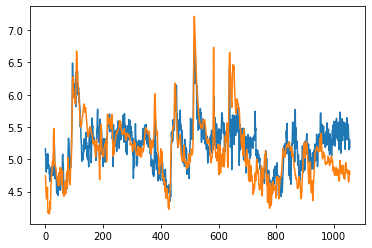

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:13<00:00,  3.07it/s]

LSTM_DROP_RELU_FC(
  (lstm): LSTM(5, 32, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
  (fc1): Linear(in_features=32, out_features=1, bias=True)
)


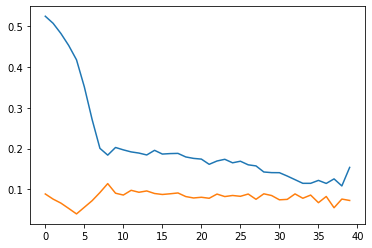

train  MSE:  0.10127716206471843
val  MSE:  0.1623859707700572
Test NSE: [-0.81998765]
Test KGE: 0.1630764964247614
test  MSE:  0.1305416238572968
Full NSE: [0.40560268]
Full KGE: 0.5168838101062349
Full  MSE:  0.12961035553759093


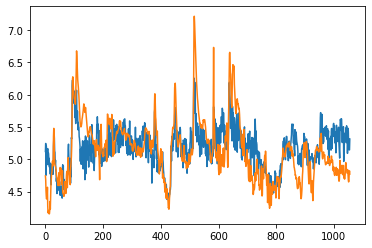

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.44it/s]

LSTM_RELU_DROP_FC(
  (lstm): LSTM(5, 32, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
  (fc1): Linear(in_features=32, out_features=1, bias=True)
)


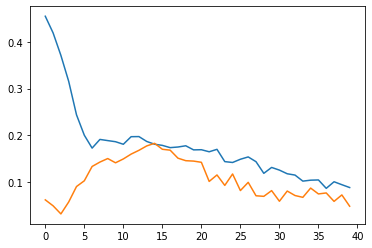

train  MSE:  0.07969934904339376
val  MSE:  0.13462029448884194
Test NSE: [-1.50182305]
Test KGE: 0.017700924876014268
test  MSE:  0.1794473956517406
Full NSE: [0.40782779]
Full KGE: 0.5965536925732675
Full  MSE:  0.12912516222340142


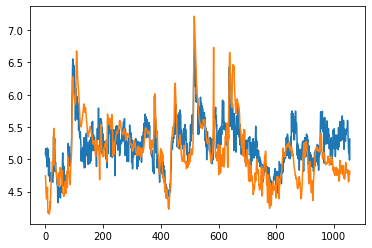

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.91it/s]

LSTM_LSTM_RELU_FC(
  (lstm): LSTM(5, 32, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=32, out_features=32, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=32, out_features=1, bias=True)
)


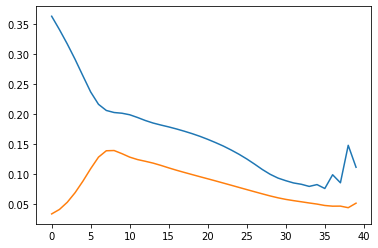

train  MSE:  0.06629881345868764
val  MSE:  0.16876263355699883
Test NSE: [-1.64825836]
Test KGE: 0.2698583598081725
test  MSE:  0.1899507102765009
Full NSE: [0.47018789]
Full KGE: 0.6041075338686547
Full  MSE:  0.11552732948353672


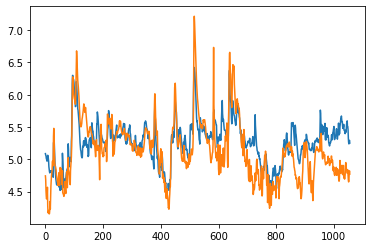

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.63it/s]

LSTM_DROP_FC_RELU_FC(
  (lstm): LSTM(5, 32, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=32, out_features=32, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=32, out_features=1, bias=True)
)


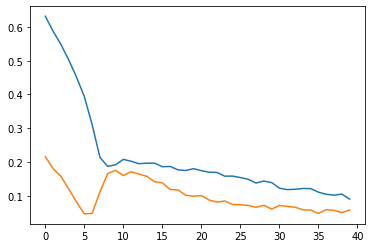

train  MSE:  0.07357491796621879
val  MSE:  0.1590354377914627
Test NSE: [-0.82862419]
Test KGE: 0.4340872435657739
test  MSE:  0.1311610936650628
Full NSE: [0.4286594]
Full KGE: 0.6366927544528118
Full  MSE:  0.12458275880527403


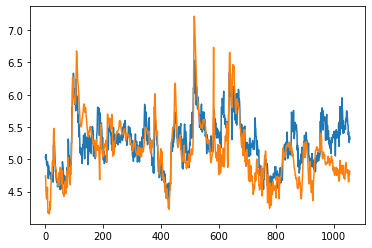

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.84it/s]

LSTM_DROP_LSTM_FC_RELU_FC(
  (lstm): LSTM(5, 32, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=32, out_features=32, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=32, out_features=1, bias=True)
)


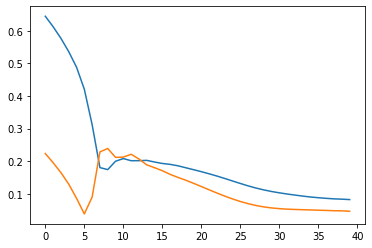

train  MSE:  0.05894983343147328
val  MSE:  0.19320124291456306
Test NSE: [-0.28234832]
Test KGE: 0.3839991596623288
test  MSE:  0.09197855367320004
Full NSE: [0.49587589]
Full KGE: 0.6655299564489237
Full  MSE:  0.10992597581939856


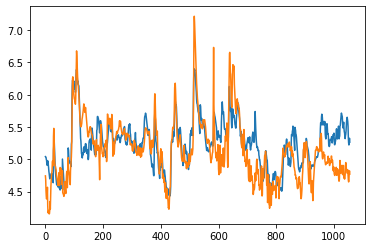

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:23<00:00,  1.69it/s]

LSTM_LSTM_FC_RELU_FC(
  (lstm): LSTM(5, 32, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=32, out_features=32, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=32, out_features=1, bias=True)
)


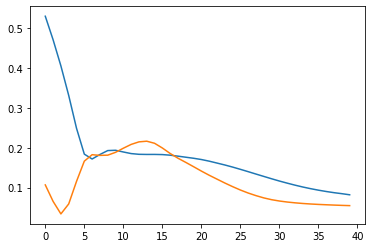

train  MSE:  0.06874232007016447
val  MSE:  0.17624745903348124
Test NSE: [-0.71028137]
Test KGE: 0.303284171121075
test  MSE:  0.12267275950147097
Full NSE: [0.4601974]
Full KGE: 0.6280282991347867
Full  MSE:  0.117705790961197


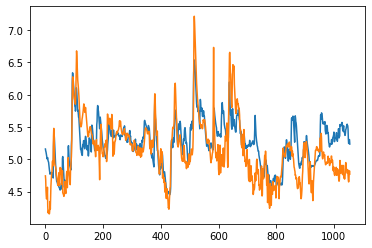

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:24<00:00,  1.65it/s]

LSTM_LSTM_FC_DROP_FC(
  (lstm): LSTM(5, 32, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=32, out_features=32, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=32, out_features=1, bias=True)
)


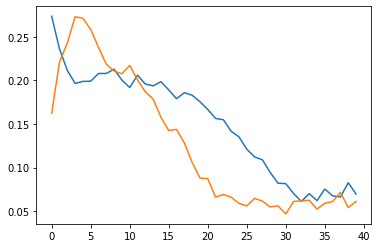

train  MSE:  0.0585016393085713
val  MSE:  0.184522843810854
Test NSE: [-0.54409484]
Test KGE: 0.24481520456353867
test  MSE:  0.11075275551751212
Full NSE: [0.49188556]
Full KGE: 0.6451070252851061
Full  MSE:  0.11079608032822272


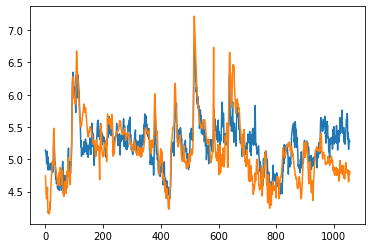

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:23<00:00,  1.69it/s]

LSTM_LSTM_FC_DROP_RELU_FC(
  (lstm): LSTM(5, 32, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=32, out_features=32, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=32, out_features=1, bias=True)
)


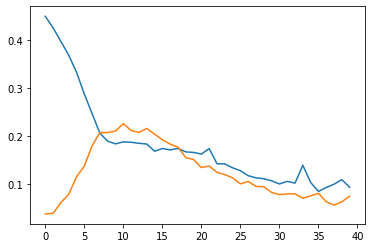

train  MSE:  0.07113130500515275
val  MSE:  0.18460547369513328
Test NSE: [-0.71876361]
Test KGE: 0.31718603123615796
test  MSE:  0.1232811624629201
Full NSE: [0.47918365]
Full KGE: 0.6741938245358381
Full  MSE:  0.11356577562343516


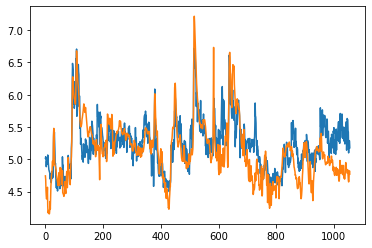

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.57it/s]

LSTM_FC_FC(
  (lstm): LSTM(5, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=32, bias=True)
  (fc1): Linear(in_features=32, out_features=1, bias=True)
)


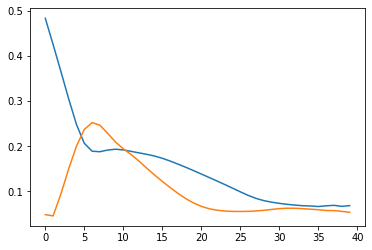

train  MSE:  0.05510156403821552
val  MSE:  0.16643304654711577
Test NSE: [-0.1313696]
Test KGE: 0.36513923692922445
test  MSE:  0.0811493553954896
Full NSE: [0.52797408]
Full KGE: 0.6896235776662423
Full  MSE:  0.10292685583515622


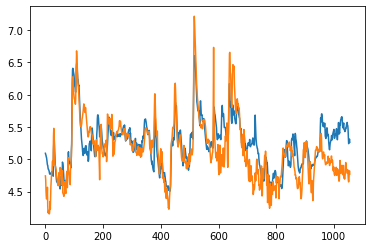

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.56it/s]

LSTM_FC_RELU_FC(
  (lstm): LSTM(5, 32, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=32, out_features=32, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=32, out_features=1, bias=True)
)


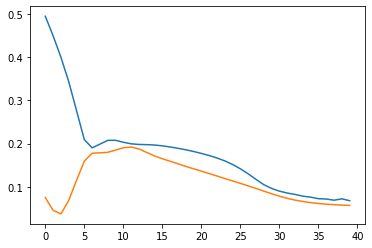

train  MSE:  0.0576811834161736
val  MSE:  0.14441514019332208
Test NSE: [-1.26536499]
Test KGE: 0.29852089046671293
test  MSE:  0.16248704971650213
Full NSE: [0.51027815]
Full KGE: 0.656571034607818
Full  MSE:  0.10678551418840418


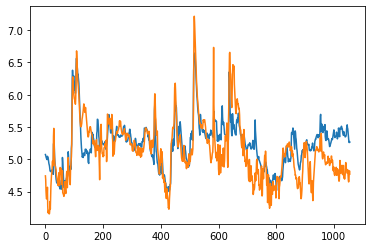

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.52it/s]

LSTM_FC_DROP_FC(
  (dropout): Dropout(p=0.1, inplace=False)
  (lstm): LSTM(5, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=32, bias=True)
  (fc1): Linear(in_features=32, out_features=1, bias=True)
)


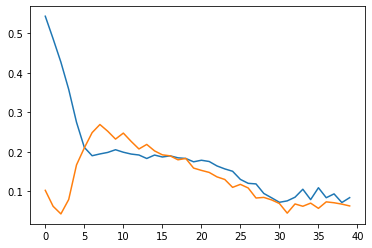

train  MSE:  0.06377989077947684
val  MSE:  0.14877660437687157
Test NSE: [-0.80981973]
Test KGE: 0.2854190954929974
test  MSE:  0.12981231319641873
Full NSE: [0.50304701]
Full KGE: 0.669734411332912
Full  MSE:  0.10836228861194154


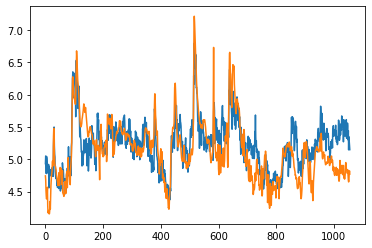

In [12]:
TEST_NSE=[]
FULL_NSE=[]
TEST_KGE=[]
FULL_KGE=[]
FULL_MSE=[]
TEST_MSE=[]
for Model in model_list:
    optimizer = torch.optim.Adam(Model.parameters(), lr=parameters['lr'])
    loss_function = nn.MSELoss()
    model, train_val_history = train_model(Model, 
                                                train_loader, 
                                                val_loader,
                                                loss_function, 
                                                optimizer, 
                                                parameters['epochs'])
    
    print(model)
    plt.plot(train_val_history['train'])
    plt.plot(train_val_history['val'])
    plt.show()
    plt.close()
    full_label=[]
    full_pred=[]

    train_label=[]
    train_pred=[]
    val_label=[]
    val_pred=[]
    test_label=[]
    test_pred=[]

    for j, data in enumerate(train_loader):
                inputs, labels = data[0].to(device), data[1].to(device)
                #optimizer.zero_grad()
                labels_3D=labels.reshape(1,labels.shape[0],labels.shape[1])
                y_pred = model(inputs)          
                train_pred.append(y_pred.squeeze().tolist())
                train_label.append(labels.squeeze().tolist())
    train_predictions_l = [item for sublist in train_pred for item in sublist]
    train_predictions=np.array(train_predictions_l).reshape(-1,1)

    train_real_y_l=[item for sublist in train_label for item in sublist]
    train_real_y=np.array(train_real_y_l).reshape(-1,1)

    train_predictions=y_scaler.inverse_transform(train_predictions)
    train_real_y=y_scaler.inverse_transform(train_real_y)
    print("train  MSE: ", mse(train_predictions, train_real_y))


    for j, data in enumerate(val_loader):
                inputs, labels = data[0].to(device), data[1].to(device)
                #optimizer.zero_grad()
                labels_3D=labels.reshape(1,labels.shape[0],labels.shape[1])
                y_pred = model(inputs)            
                val_pred.append(y_pred.squeeze().tolist())
                val_label.append(labels.squeeze().tolist())


    val_predictions_l = [item for sublist in val_pred for item in sublist]
    val_predictions=np.array(val_predictions_l).reshape(-1,1)

    val_real_y_l=[item for sublist in val_label for item in sublist]
    val_real_y=np.array(val_real_y_l).reshape(-1,1)

    val_predictions=y_scaler.inverse_transform(val_predictions)
    val_real_y=y_scaler.inverse_transform(val_real_y)
    print("val  MSE: ", mse(val_predictions, val_real_y))

    for j, data in enumerate(test_loader):
                inputs, labels = data[0].to(device), data[1].to(device)
                #optimizer.zero_grad()
                labels_3D=labels.reshape(1,labels.shape[0],labels.shape[1])
                y_pred = model(inputs)        
                test_pred.append(y_pred.squeeze().tolist())
                test_label.append(labels.squeeze().tolist())

    test_predictions_l = [item for sublist in test_pred for item in sublist]
    test_predictions=np.array(test_predictions_l).reshape(-1,1)

    test_real_y_l=[item for sublist in test_label for item in sublist]
    test_real_y=np.array(test_real_y_l).reshape(-1,1)

    test_predictions=y_scaler.inverse_transform(test_predictions)
    test_real_y=y_scaler.inverse_transform(test_real_y)
    
    test_nse=evaluator(nse, test_predictions, test_real_y)
    print("Test NSE:", test_nse)
    TEST_NSE.append(test_nse)
    
    test_kge=evaluator(kge, test_predictions, test_real_y)[0][0]
    print("Test KGE:", test_kge)
    TEST_KGE.append(test_kge)

    test_mse=mse(test_predictions, test_real_y)
    print("test  MSE: ", test_mse)
    TEST_MSE.append(test_mse)
    
    full_pred=[]
    full_label=[]
    for j, data in enumerate(full_loader):
                inputs, labels = data[0].to(device), data[1].to(device)
                #optimizer.zero_grad()
                labels_3D=labels.reshape(1,labels.shape[0],labels.shape[1])
                y_pred = model(inputs)
                full_pred.append(y_pred.squeeze().tolist())
                full_label.append(labels.squeeze().tolist())

    full_predictions_l = [item for sublist in full_pred for item in sublist]
    full_predictions=np.array(full_predictions_l).reshape(-1,1)

    full_real_y_l=[item for sublist in full_label for item in sublist]
    full_real_y=np.array(full_real_y_l).reshape(-1,1)

    full_predictions=y_scaler.inverse_transform(full_predictions)
    full_real_y=y_scaler.inverse_transform(full_real_y)

    full_nse=evaluator(nse, full_predictions, full_real_y)
    print("Full NSE:", full_nse)
    FULL_NSE.append(full_nse)
    
    full_kge=evaluator(kge, full_predictions, full_real_y)[0][0]
    print("Full KGE:", full_kge)
    FULL_KGE.append(full_kge)

    full_mse=mse(full_predictions, full_real_y)
    print("Full  MSE: ", full_mse)
    FULL_MSE.append(full_mse)
    

    plt.plot(full_predictions)
    plt.plot(full_real_y)
    plt.show()
    plt.close()

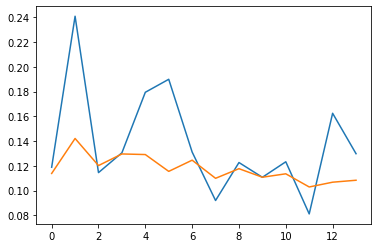

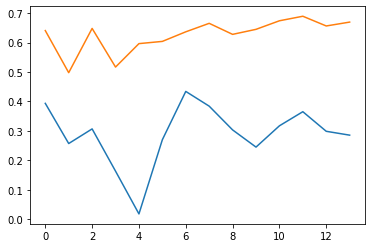

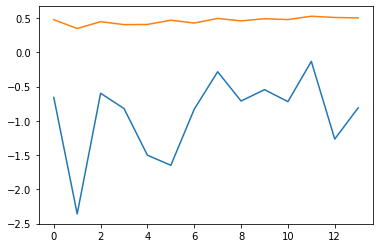

In [13]:
plt.plot(TEST_MSE)
plt.plot(FULL_MSE)
plt.show()
plt.close()
plt.plot(TEST_KGE)
plt.plot(FULL_KGE)
plt.show()
plt.close()
plt.plot(TEST_NSE)
plt.plot(FULL_NSE)
plt.show()
plt.close()

### From the Above Resutls we see that he LSTM_FC_FC (No dropout) performs the best

In [ ]:
test_list=[] 
labels_list=[]
for j, data in enumerate(test_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            #optimizer.zero_grad()
            labels_3D=labels.reshape(1,labels.shape[0],labels.shape[1])
            y_pred = New_LSTM(inputs)
            test_list.append(y_pred.squeeze().tolist())
            labels_list.append(labels.squeeze().tolist())
            single_loss = torch.sqrt(loss_function(y_pred, labels_3D))
predic_list = [item for sublist in test_list for item in sublist]
predictions=np.array(predic_list).reshape(-1,1)

real_y_list=[item for sublist in labels_list for item in sublist]
real_y=np.array(real_y_list).reshape(-1,1)

predictions=y_scaler.inverse_transform(predictions)
real_y=y_scaler.inverse_transform(real_y)
#print(predictions.shape)
plt.plot(predictions)
plt.plot(real_y)

from sklearn.metrics import mean_squared_error as mse

mse(predictions, real_y)

In [224]:
from sklearn.metrics import mean_squared_error as mse

full_label=[]
full_pred=[]

train_label=[]
train_pred=[]
val_label=[]
val_pred=[]
test_label=[]
test_pred=[]

for j, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            #optimizer.zero_grad()
            labels_3D=labels.reshape(1,labels.shape[0],labels.shape[1])
            y_pred = New_LSTM(inputs)          
            train_pred.append(y_pred.squeeze().tolist())
            train_label.append(labels.squeeze().tolist())
train_predictions_l = [item for sublist in train_pred for item in sublist]
train_predictions=np.array(train_predictions_l).reshape(-1,1)

train_real_y_l=[item for sublist in train_label for item in sublist]
train_real_y=np.array(train_real_y_l).reshape(-1,1)

train_predictions=y_scaler.inverse_transform(train_predictions)
train_real_y=y_scaler.inverse_transform(train_real_y)
print("train  MSE: ", mse(train_predictions, train_real_y))


for j, data in enumerate(val_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            #optimizer.zero_grad()
            labels_3D=labels.reshape(1,labels.shape[0],labels.shape[1])
            y_pred = New_LSTM(inputs)            
            val_pred.append(y_pred.squeeze().tolist())
            val_label.append(labels.squeeze().tolist())


val_predictions_l = [item for sublist in val_pred for item in sublist]
val_predictions=np.array(val_predictions_l).reshape(-1,1)

val_real_y_l=[item for sublist in val_label for item in sublist]
val_real_y=np.array(val_real_y_l).reshape(-1,1)

val_predictions=y_scaler.inverse_transform(val_predictions)
val_real_y=y_scaler.inverse_transform(val_real_y)
print("val  MSE: ", mse(val_predictions, val_real_y))

for j, data in enumerate(test_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            #optimizer.zero_grad()
            labels_3D=labels.reshape(1,labels.shape[0],labels.shape[1])
            y_pred = New_LSTM(inputs)        
            test_pred.append(y_pred.squeeze().tolist())
            test_label.append(labels.squeeze().tolist())

test_predictions_l = [item for sublist in test_pred for item in sublist]
test_predictions=np.array(test_predictions_l).reshape(-1,1)

test_real_y_l=[item for sublist in test_label for item in sublist]
test_real_y=np.array(test_real_y_l).reshape(-1,1)

test_predictions=y_scaler.inverse_transform(test_predictions)
test_real_y=y_scaler.inverse_transform(test_real_y)
print("test  MSE: ", mse(test_predictions, test_real_y))

ValueError: Found input variables with inconsistent numbers of samples: [36864, 576]

Full MSE:  0.14893966129152075


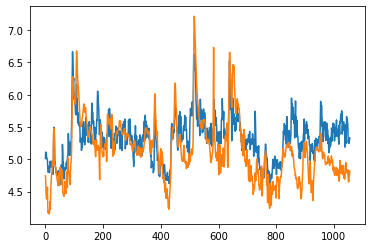

In [211]:
full_pred=[]
full_label=[]
for j, data in enumerate(full_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            #optimizer.zero_grad()
            labels_3D=labels.reshape(1,labels.shape[0],labels.shape[1])
            y_pred = New_LSTM(inputs)
            full_pred.append(y_pred.squeeze().tolist())
            full_label.append(labels.squeeze().tolist())

full_predictions_l = [item for sublist in full_pred for item in sublist]
full_predictions=np.array(full_predictions_l).reshape(-1,1)

full_real_y_l=[item for sublist in full_label for item in sublist]
full_real_y=np.array(full_real_y_l).reshape(-1,1)

full_predictions=y_scaler.inverse_transform(full_predictions)
full_real_y=y_scaler.inverse_transform(full_real_y)

print("Full MSE: ", mse(full_predictions, full_real_y))

plt.plot(full_predictions)
plt.plot(full_real_y)


In [201]:
train  MSE:  0.03400184075674894
val  MSE:  0.10336342906543683
test  MSE:  0.04382218300791058

SyntaxError: invalid syntax (<ipython-input-201-8888cefd2a13>, line 1)